In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score

snr_list = ['6_dB', '-6_dB', '0_dB']

def read_csv_files(snr, pattern='anomaly_score_*.csv', test=False):
    if test:
        return glob.glob(os.path.join(snr, 'test', pattern))
    else:
        return glob.glob(os.path.join(snr ,pattern))
    
# 파일 이름에서 레이블을 결정하는 함수
def get_label(filename):
    if 'anomaly' in filename:
        return 1
    else:
        return 0

def get_labels_and_scores(csv_files):
    actual_labels = []
    anomaly_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())
    return pd.Series(actual_labels), pd.Series(anomaly_scores)



In [2]:
def get_labels_and_scores_n(csv_files):
    actual_labels = []
    anomaly_scores = []
    normal_anomaly_scores = []
    abnormal_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())

        normal_scores = df[df['label'] == 0]['anomaly_score']
        abnormal_score = df[df['label']==1]['anomaly_score']
        if not normal_scores.empty:
            normal_anomaly_scores.extend(normal_scores.tolist())
        abnormal_scores.extend(abnormal_score)
    return actual_labels, anomaly_scores, normal_anomaly_scores, abnormal_scores

['DECASE/anomaly_score_fan_id_00.csv', 'DECASE/anomaly_score_fan_id_02.csv', 'DECASE/anomaly_score_fan_id_04.csv', 'DECASE/anomaly_score_fan_id_06.csv', 'DECASE/anomaly_score_pump_id_00.csv', 'DECASE/anomaly_score_pump_id_02.csv', 'DECASE/anomaly_score_pump_id_04.csv', 'DECASE/anomaly_score_pump_id_06.csv', 'DECASE/anomaly_score_slider_id_00.csv', 'DECASE/anomaly_score_slider_id_02.csv', 'DECASE/anomaly_score_slider_id_04.csv', 'DECASE/anomaly_score_slider_id_06.csv', 'DECASE/anomaly_score_valve_id_00.csv', 'DECASE/anomaly_score_valve_id_02.csv', 'DECASE/anomaly_score_valve_id_04.csv', 'DECASE/anomaly_score_valve_id_06.csv']
4900
1600
3300


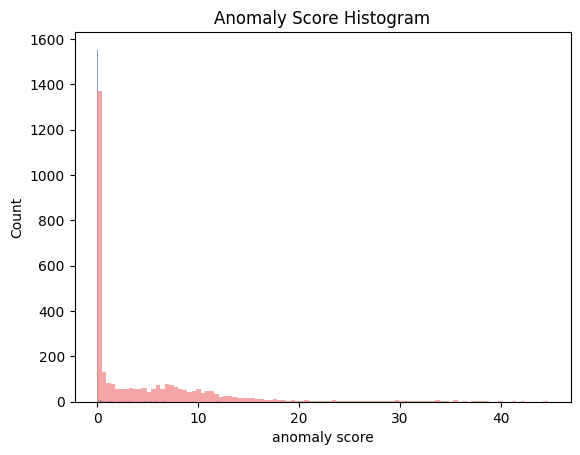

<Figure size 1000x700 with 0 Axes>

In [9]:
def draw_anomaly_score(anomaly_scores, abnormal_scores):
    plt.hist(anomaly_scores, bins = 100, alpha=0.7, color='steelblue', histtype='stepfilled')
    plt.hist(abnormal_scores, bins = 100,alpha=0.7,  color='lightcoral', histtype='stepfilled')
    plt.title(f'Anomaly Score Histogram')
    plt.xlabel('anomaly score')
    # plt.xlim([0,5]) 
    plt.ylabel('Count')
    plt.figure(figsize=(10, 7))

def process_anomaly_score(test=False):
    if test and not os.path.isdir('./testfig'):
        os.mkdir('./testfig')
    csv_files = read_csv_files('DECASE',test=test)
    print(sorted(csv_files))
    actual_labels, tot, normal_anomaly_scores, abnormal_scores = get_labels_and_scores_n(csv_files)
    print(len(tot))
    print(len(normal_anomaly_scores))
    print(len(abnormal_scores))
    draw_anomaly_score(normal_anomaly_scores, abnormal_scores)
    

process_anomaly_score(test=False)

SNR: 6_dB
Optimal threshold: 0.22
F1 Score: 0.49148211243611584
AUC: 0.9192146448793395


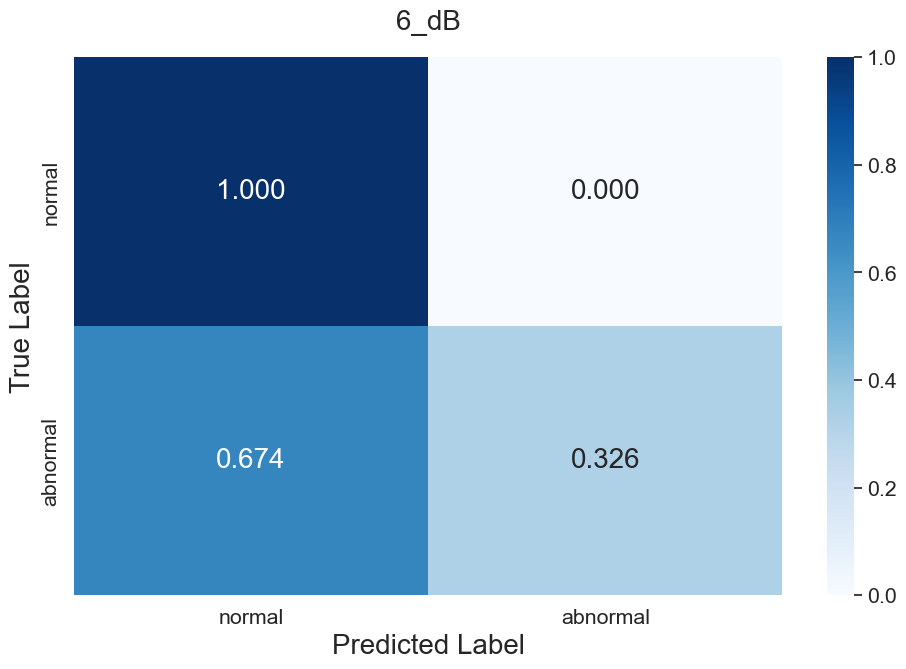

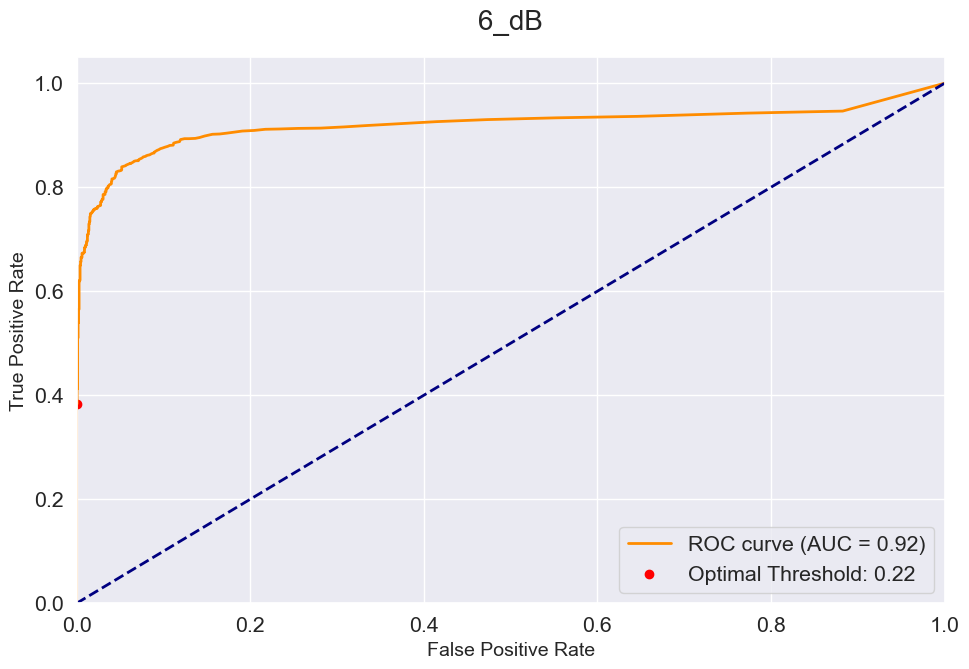

SNR: -6_dB
Optimal threshold: 0.55
F1 Score: 0.6177811550151976
AUC: 0.8653740019340393


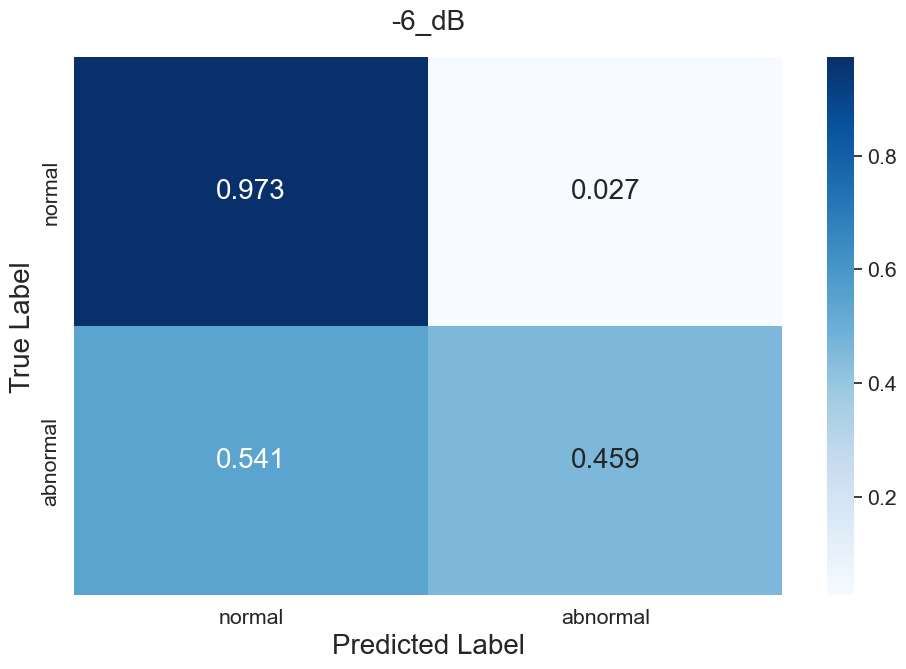

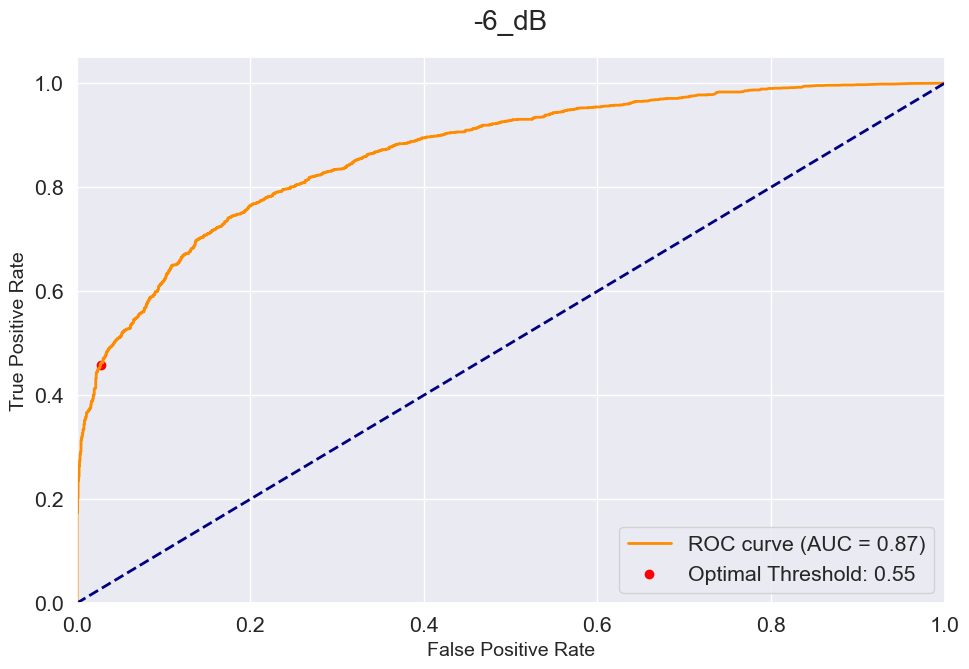

SNR: 0_dB
Optimal threshold: 0.4
F1 Score: 0.5227177990829512
AUC: 0.8787268754617097


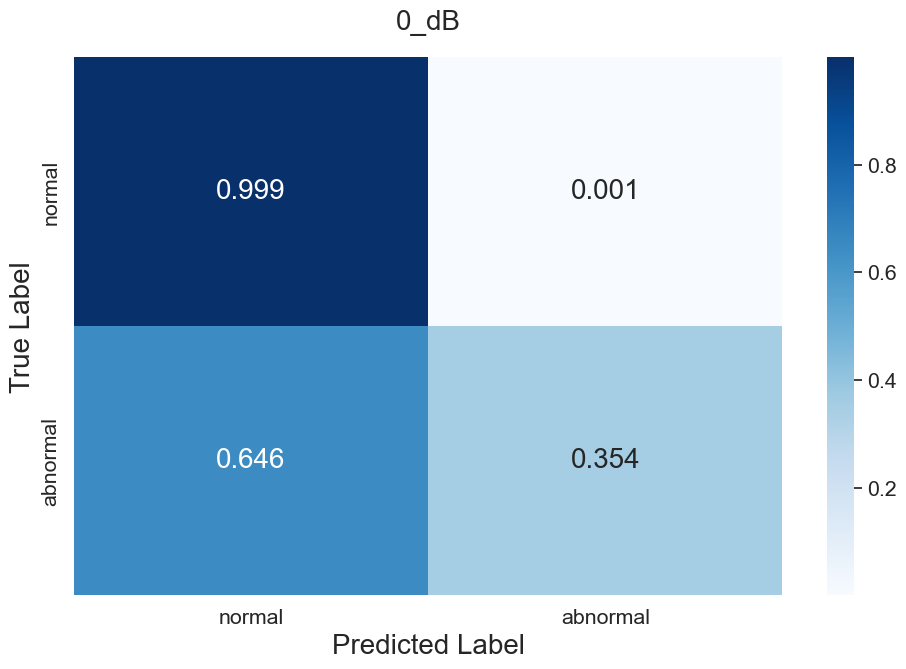

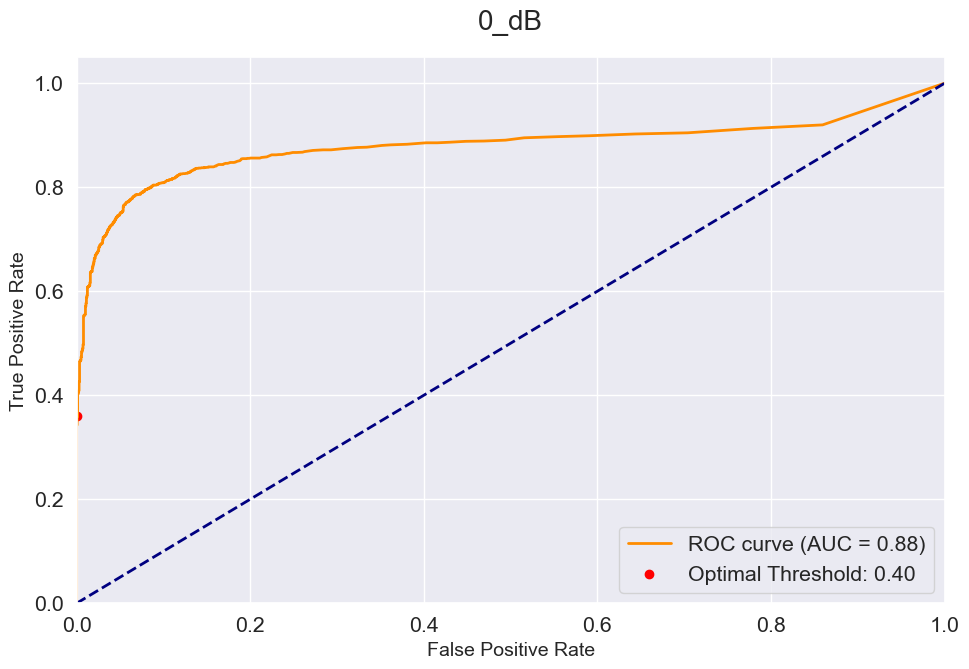

In [39]:
def calculate_metrics(snr, dic, actual_labels, anomaly_scores):
    optimal_threshold = dic[snr]
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
    fpr, tpr, thresholds = roc_curve(actual_labels, anomaly_scores)
    auc = roc_auc_score(actual_labels, anomaly_scores)
    f1 = f1_score(actual_labels, predicted_labels)
    optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    return predicted_labels, optimal_threshold, f1, auc, fpr, tpr, optimal_idx

def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.close() 


def draw_roc_curve(fpr, tpr, auc, snr, optimal_idx, optimal_threshold, test=False):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    
    plt.close() 

def use_eye(snr, dic, test=False):
    if test and not os.path.isdir('./testfig'):
        os.mkdir('./testfig')
    csv_files = read_csv_files(snr, test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics(snr, dic, actual_labels, anomaly_scores)
    predicted_labels, optimal_threshold, f1, auc, fpr, tpr, optimal_idx = results
    
    print(f'SNR: {snr}')
    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    draw_roc_curve(fpr, tpr, auc, snr, optimal_idx, optimal_threshold, test)
    
    return results

dic = {
    '-6_dB' : 0.55,
    '0_dB'  : 0.4,
    '6_dB'  : 0.22
    }


for snr in snr_list:
    use_eye(snr, dic, test=False)


SNR: 6_dB
Optimal threshold: 7.510157e-06
F1 Score: 0.9280315478146566


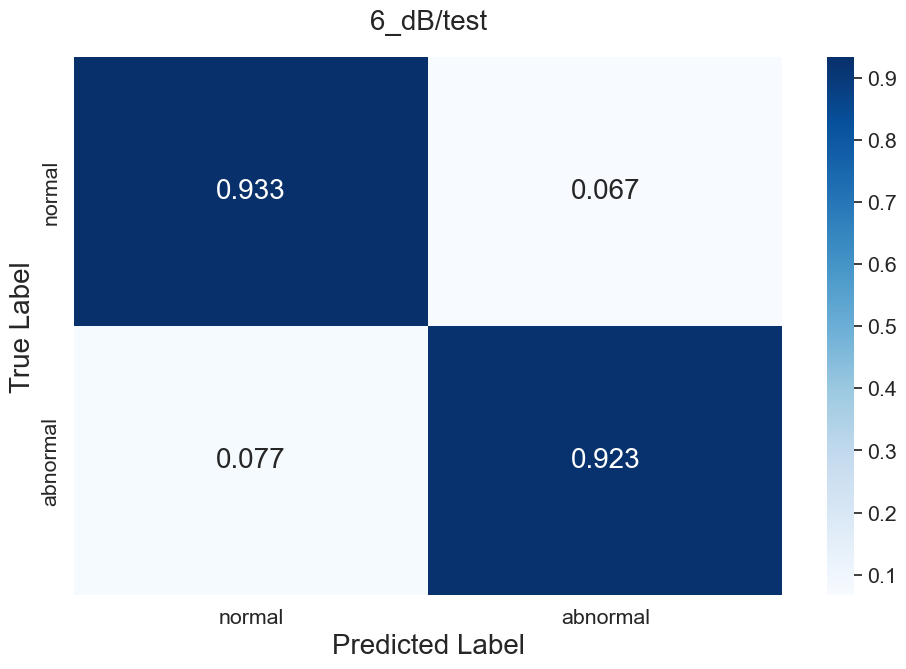

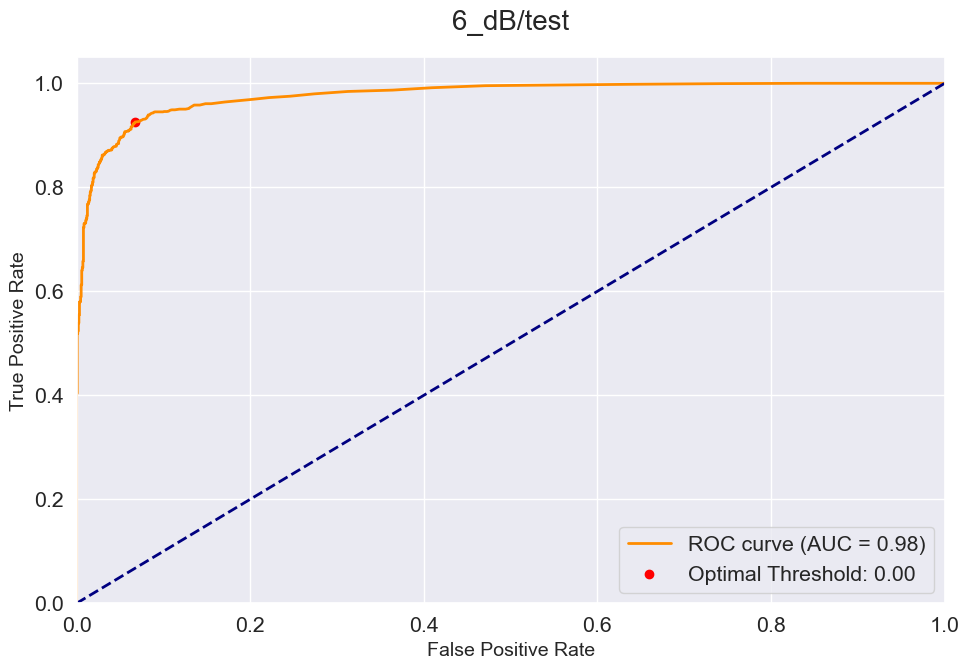

SNR: -6_dB
Optimal threshold: 0.011119776
F1 Score: 0.7691192461036608


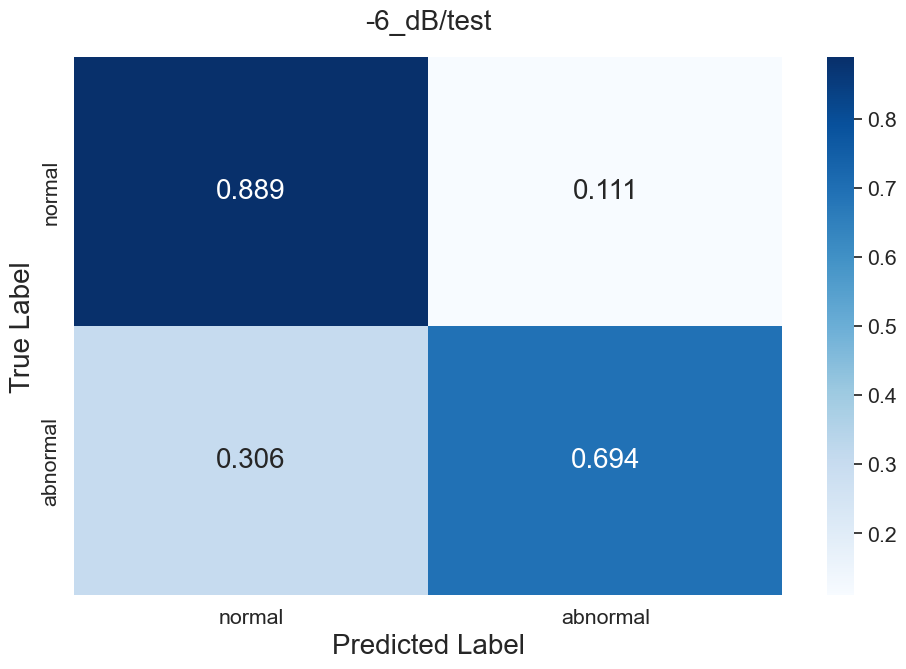

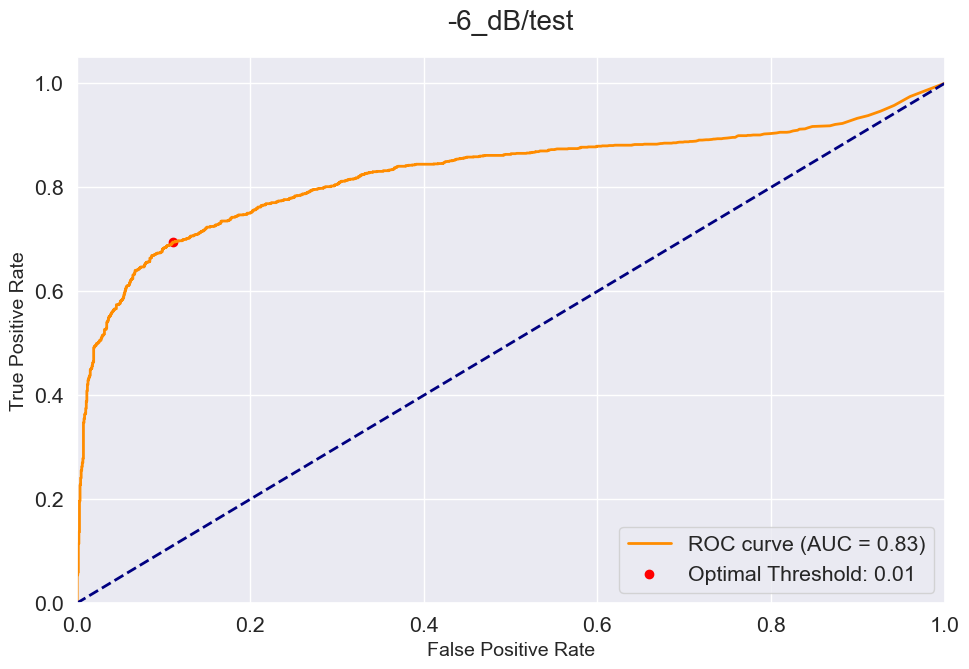

SNR: 0_dB
Optimal threshold: 6.9854206e-05
F1 Score: 0.857640097459102


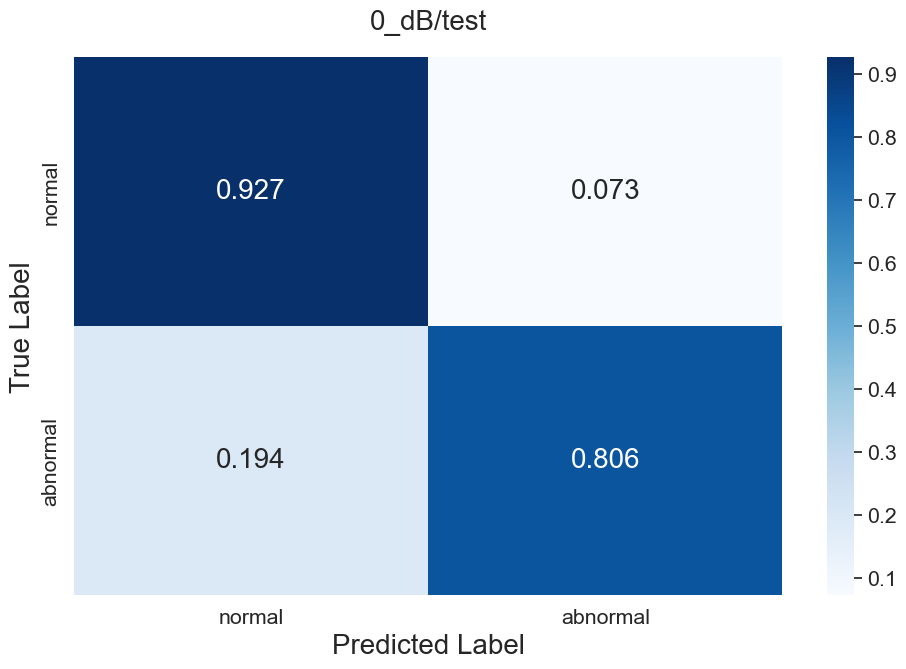

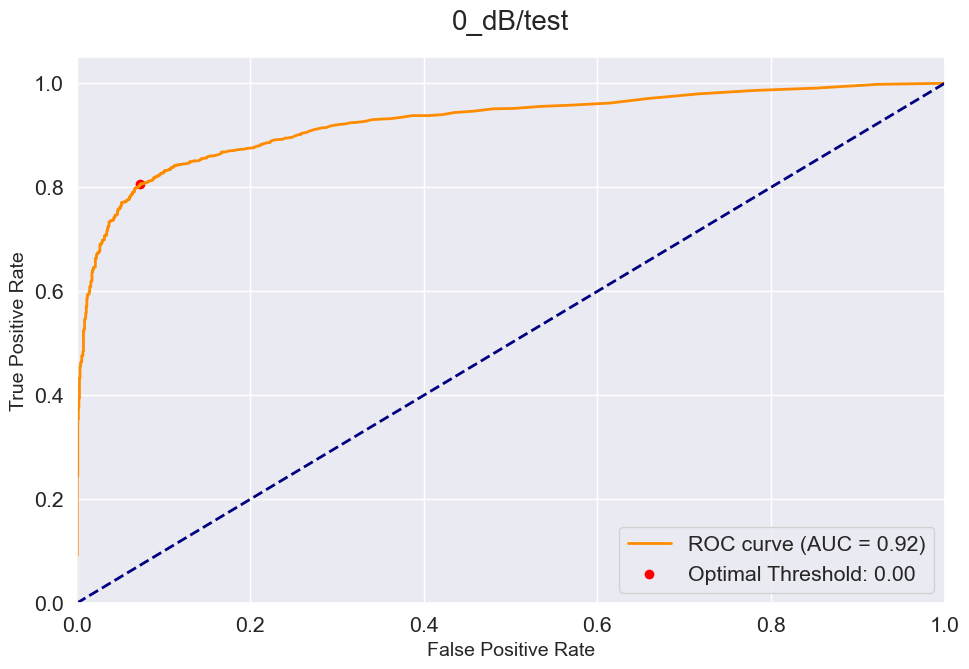

In [40]:
def calculate_metrics(actual_labels, anomaly_scores):
    fpr, tpr, thresholds = roc_curve(actual_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
    f1 = f1_score(actual_labels, predicted_labels)
    return predicted_labels, fpr, tpr, optimal_idx, roc_auc, optimal_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.close() 

def draw_roc_curve(fpr, tpr, roc_auc, optimal_idx, optimal_threshold, snr, test=False):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    
    plt.close() 

def use_Youden_inedex(snr, test=False):
    csv_files = read_csv_files(snr, test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics(actual_labels, anomaly_scores)
    predicted_labels, fpr, tpr, optimal_idx, roc_auc, optimal_threshold, f1 = results
    
    print(f'SNR: {snr}')
    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    draw_roc_curve(fpr, tpr, roc_auc, optimal_idx, optimal_threshold, snr, test)
    
    return results

for snr in snr_list:
    use_Youden_inedex(snr, test=True)

SNR: 6_dB
Z-Score Threshold: 2
F1 Score: 0.1677651288196525


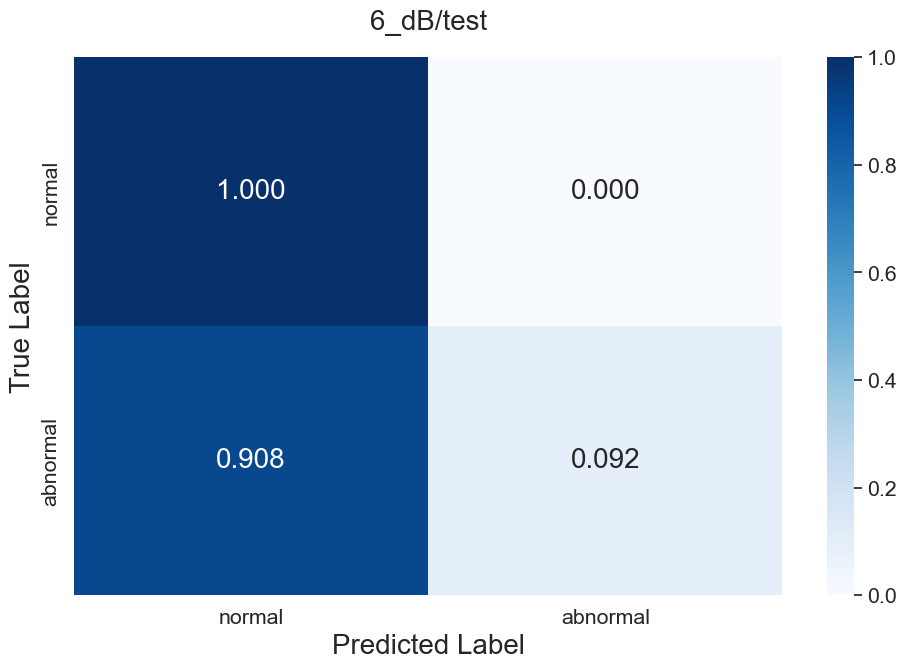

SNR: -6_dB
Z-Score Threshold: 2
F1 Score: 0.23183391003460208


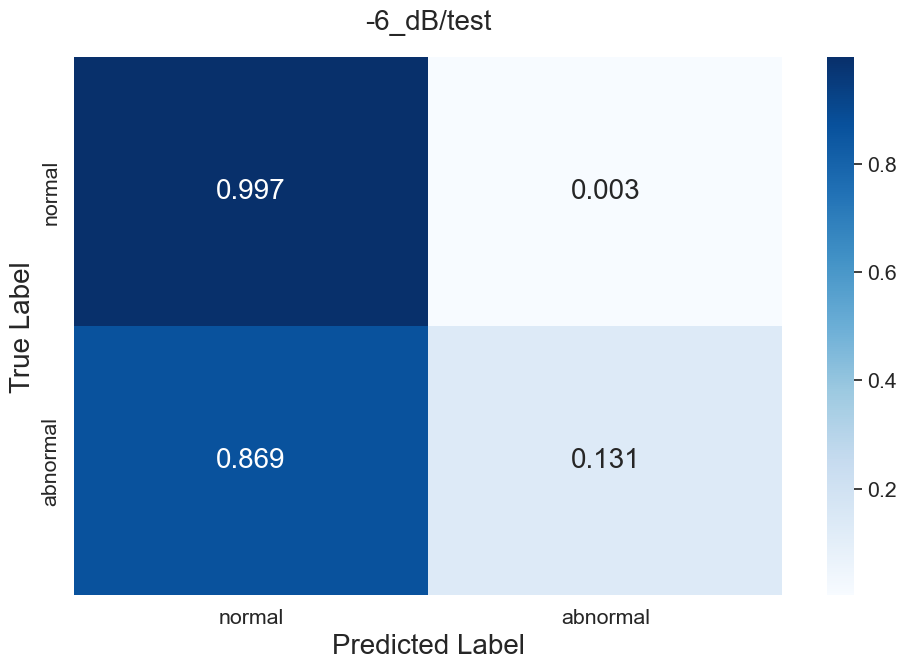

SNR: 0_dB
Z-Score Threshold: 2
F1 Score: 0.18397626112759644


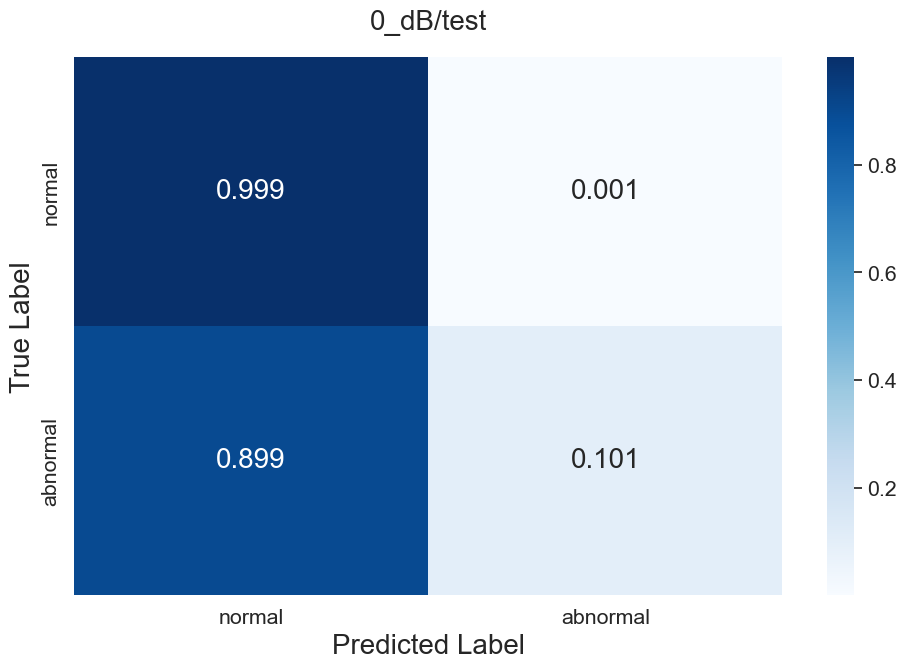

In [42]:
def calculate_metrics_zscore(actual_labels, anomaly_scores, z_threshold=2):
    normal_mean = np.mean(anomaly_scores)
    normal_std = np.std(anomaly_scores)

    # Z-Score 계산
    z_scores = (anomaly_scores - normal_mean) / normal_std
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (z_scores > z_threshold).astype(int)

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.close() 

def use_zscore(snr, test=False):
    csv_files = read_csv_files(snr, test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics_zscore(actual_labels, anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'SNR: {snr}')
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
    return results

for snr in snr_list:
    use_zscore(snr, test=True)


SNR: 6_dB
Z-Score Threshold: 2
F1 Score: 0.6655037069341474


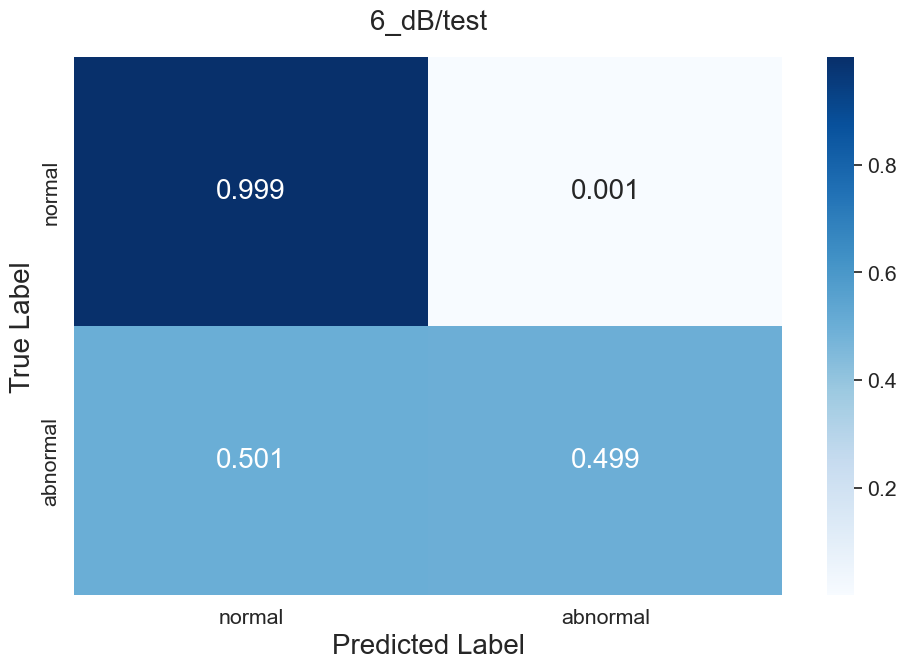

SNR: -6_dB
Z-Score Threshold: 2
F1 Score: 0.5873233014135887


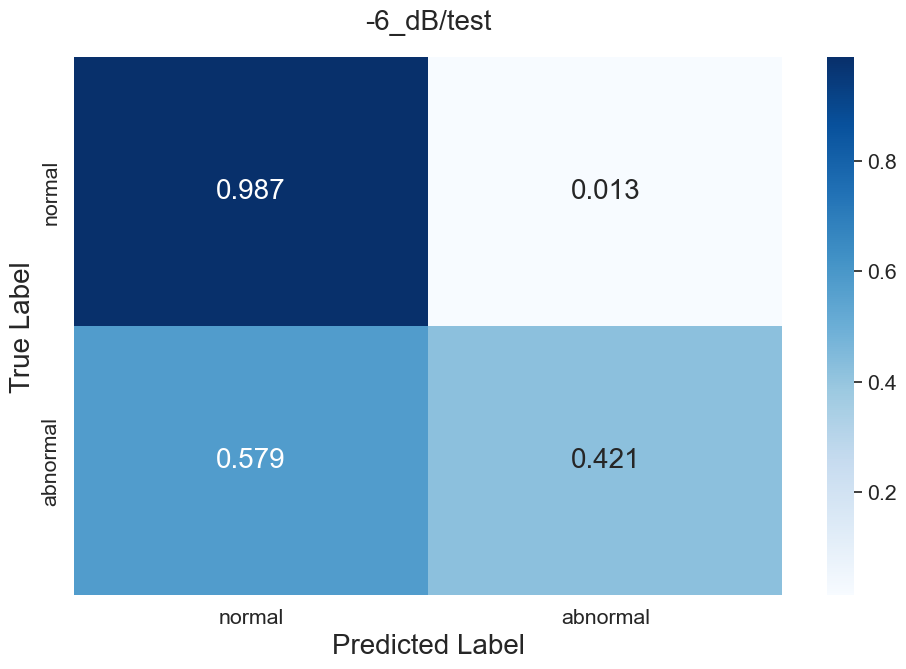

SNR: 0_dB
Z-Score Threshold: 2
F1 Score: 0.6261180679785331


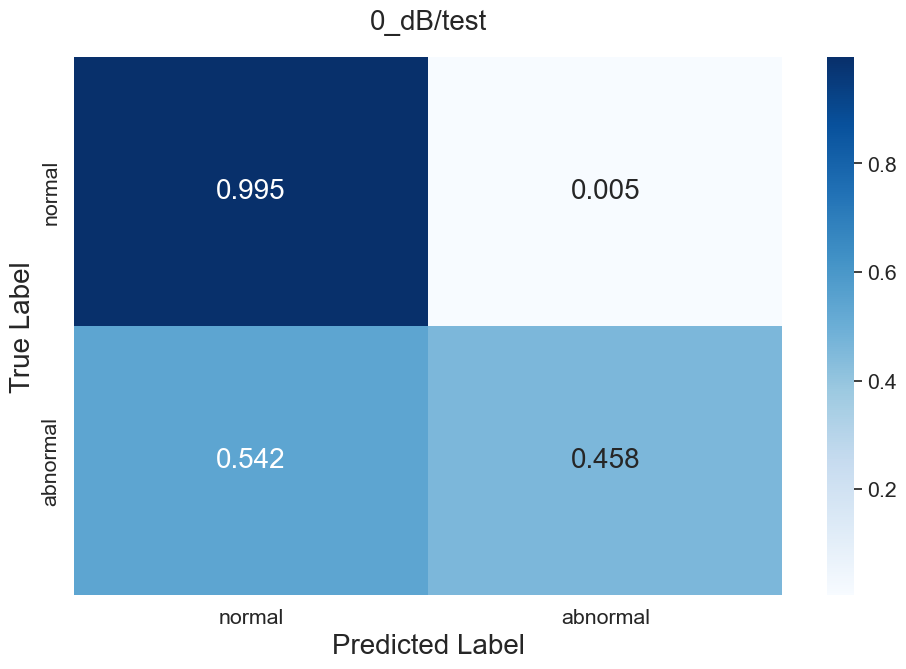

In [43]:
def get_labels_and_scores_n(csv_files):
    actual_labels = []
    anomaly_scores = []
    normal_anomaly_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())

        normal_scores = df[df['label'] == 0]['anomaly_score']
        if not normal_scores.empty:
            normal_anomaly_scores.extend(normal_scores.tolist())
    return pd.Series(actual_labels), pd.Series(anomaly_scores), pd.Series(normal_anomaly_scores)

def calculate_metrics_zscore(actual_labels, anomaly_scores, normal_anomaly_scores, z_threshold=2):
    normal_mean = np.mean(normal_anomaly_scores)
    normal_std = np.std(normal_anomaly_scores)

    # Z-Score 계산
    z_scores = (anomaly_scores - normal_mean) / normal_std
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (z_scores > z_threshold).astype(int)

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.close() 

def use_zscore(snr, test=False):
    csv_files = read_csv_files(snr, test=test)
    actual_labels, anomaly_scores, normal_anomaly_scores = get_labels_and_scores_n(csv_files)
    results = calculate_metrics_zscore(actual_labels, anomaly_scores, normal_anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'SNR: {snr}')
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
    return results

for snr in snr_list:
    use_zscore(snr, test=True)


SNR: 6_dB
Z-Score Threshold: 3.5
F1 Score: 0.8912579957356077


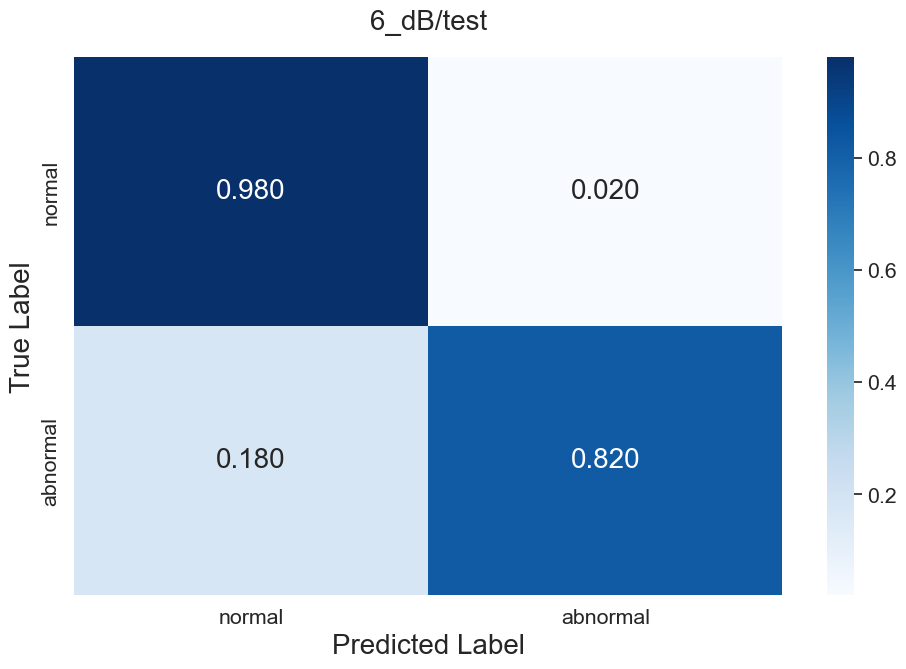

SNR: -6_dB
Z-Score Threshold: 3.5
F1 Score: 0.7691766361717101


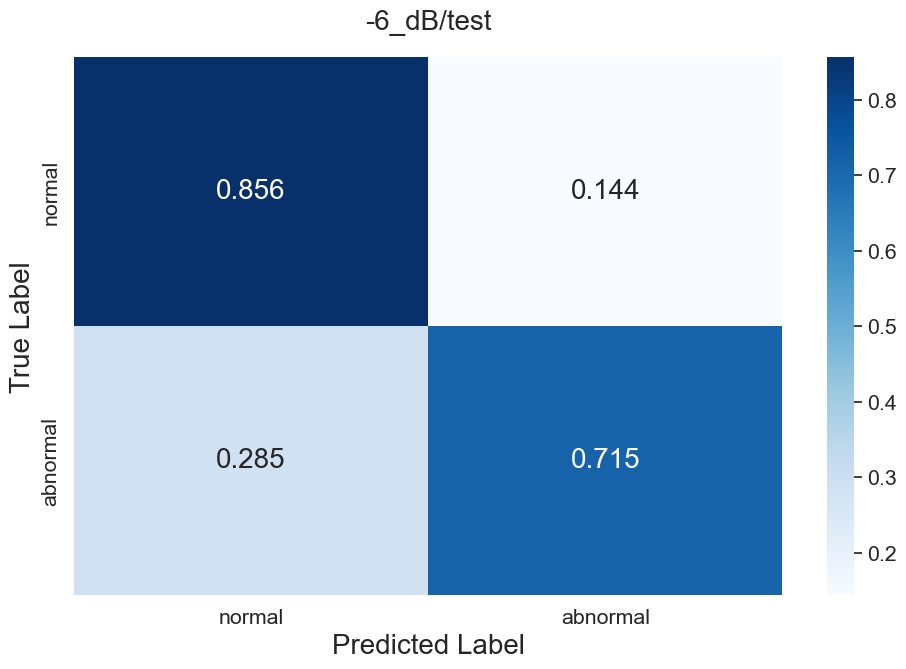

SNR: 0_dB
Z-Score Threshold: 3.5
F1 Score: 0.8505828329212293


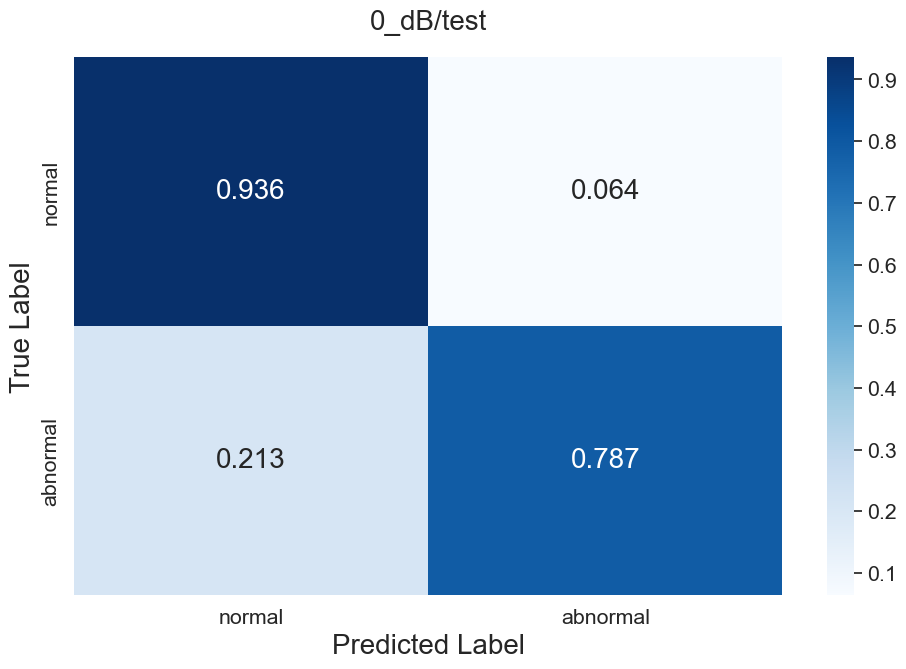

In [44]:
def calculate_metrics_modified_zscore(actual_labels, anomaly_scores, z_threshold=3.5):
    median = np.median(anomaly_scores)
    median_absolute_deviation = np.median(np.abs(anomaly_scores-median))

    # Z-Score 계산
    modified_z_scores = 0.6745*(anomaly_scores - median) / median_absolute_deviation
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (np.abs(modified_z_scores) > z_threshold).astype('int')

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1
    

def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.close() 

def use_modified_zscore(snr, test=False):
    csv_files = read_csv_files(snr, test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics_modified_zscore(actual_labels, anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'SNR: {snr}')
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
    return results

for snr in snr_list:
    use_modified_zscore(snr, test=True)


In [46]:
# def calculate_metrics_IQR(actual_labels, anomaly_scores, z_threshold=3.5):
#     quartile_1, quartile_3 = np.percentile(anomaly_scores, [25, 75])
#     iqr = quartile_3 - quartile_1
#     lower_bound = quartile_1 - (iqr * 1.5)
#     upper_bound = quartile_3 + (iqr * 1.5)


#     predicted_labels = ((anomaly_scores > upper_bound) | (anomaly_scores < lower_bound)).astype('int')

#     # F1 Score 계산
#     f1 = f1_score(actual_labels, predicted_labels)

#     return predicted_labels, z_threshold, f1
    

# def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
#     cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
#     plt.figure(figsize=(10, 7))
#     sns.set(font_scale=1.4)
#     sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
#                 yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
#     plt.xlabel('Predicted Label', fontsize=20)
#     plt.ylabel('True Label', fontsize=20)

#     if test:
#         plt.title(f'{snr}/test', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     else:
#         plt.title(f'{snr}', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     plt.close() 

# def use_IQR(snr, test=False):
#     csv_files = read_csv_files(snr, test=test)
#     actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
#     results = calculate_metrics_IQR(actual_labels, anomaly_scores)
#     predicted_labels, z_threshold, f1 = results
    
#     print(f'SNR: {snr}')
#     print(f'Z-Score Threshold: {z_threshold}')
#     print(f'F1 Score: {f1}')
    
#     draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
#     return results

# for snr in snr_list:
#     use_IQR(snr, test=True)


In [47]:
# def calculate_metrics_IQR_n(actual_labels, anomaly_scores, normal_anomaly_scores):
#     quartile_1, quartile_3 = np.percentile(normal_anomaly_scores, [25, 75])
#     iqr = quartile_3 - quartile_1
#     lower_bound = quartile_1 - (iqr * 1.5)
#     upper_bound = quartile_3 + (iqr * 1.5)


#     predicted_labels = ((anomaly_scores > upper_bound) | (anomaly_scores < lower_bound)).astype('int')

#     # F1 Score 계산
#     f1 = f1_score(actual_labels, predicted_labels)

#     return predicted_labels, f1
    

# def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
#     cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
#     plt.figure(figsize=(10, 7))
#     sns.set(font_scale=1.4)
#     sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
#                 yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
#     plt.xlabel('Predicted Label', fontsize=20)
#     plt.ylabel('True Label', fontsize=20)

#     if test:
#         plt.title(f'{snr}/test', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     else:
#         plt.title(f'{snr}', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     plt.close() 

# def use_IQR(snr, test=False):
#     csv_files = read_csv_files(snr, test=test)
#     actual_labels, anomaly_scores, normal_anomaly_scores = get_labels_and_scores_n(csv_files)
#     results = calculate_metrics_IQR_n(actual_labels, anomaly_scores, normal_anomaly_scores)
#     predicted_labels, f1 = results
    
#     print(f'SNR: {snr}')
#     print(f'F1 Score: {f1}')
    
#     draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
#     return results

# for snr in snr_list:
#     use_IQR(snr, test=False)


In [48]:
# def max_f1score(actual_labels, anomaly_scores, snr):
#     precision, recall, thresholds = precision_recall_curve(actual_labels, anomaly_scores)
#     f1_score =  2 * (precision * recall) / (precision + recall)

#     optimal_idx = np.argmax(f1_score)
#     optimal_threshold = thresholds[optimal_idx]
#     predicted_labels = (anomaly_scores > optimal_threshold).astype(int)

#     # Precision-Recall Curve 시각화
#     plt.figure(figsize=(10, 7))
#     plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
#     plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold}')
#     plt.xlabel('Recall', fontsize=14)
#     plt.ylabel('Precision', fontsize=14)
#     plt.title(f'{snr} Precision-Recall Curve', fontsize=16)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return optimal_threshold, predicted_labels, f1_score[optimal_idx]

# def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
#     cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
#     plt.figure(figsize=(10, 7))
#     sns.set(font_scale=1.4)
#     sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
#                 yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
#     plt.xlabel('Predicted Label', fontsize=20)
#     plt.ylabel('True Label', fontsize=20)

#     if test:
#         plt.title(f'{snr}/test', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.savefig(f'./testfig/confusion_matrix_{snr}')
#     else:
#         plt.title(f'{snr}', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.savefig(f'./confusion_matrix_{snr}')
#     plt.show() 

# def use_max_f1(snr, test=False):
#     csv_files = read_csv_files(snr, test=test)
#     actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
#     optimal_threshold, predicted_labels, f1 = max_f1score(actual_labels, anomaly_scores, snr)
    
#     draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
#     AUPRC = average_precision_score(actual_labels, anomaly_scores)

#     print(f'SNR: {snr}')
#     print(f'Optimal threshold: {optimal_threshold}')
#     print(f'F1 Score: {f1}')
#     print(f'Average Precision Score: {AUPRC}')

# for snr in snr_list:
#     use_max_f1(snr, test=False)
